# Практическим проектом нашего курса будет анализ активности студентов онлайн курса Введение в анализ данных в R

## Описание данных:

<b>events_train.csv</b> - данные о действиях, которые совершают студенты со стэпами

1. step_id - id стэпа
2. user_id - анонимизированный id юзера
3. timestamp - время наступления события в формате unix date
4. action - событие, возможные значения: 
 - discovered - пользователь перешел на стэп
 - viewed - просмотр шага,
 - started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
 - passed - удачное решение практического шага

<b>submissions_train.csv</b> - данные о времени и статусах сабмитов к практическим заданиям

1. step_id - id стэпа
2. timestamp - время отправки решения в формате unix date
3. submission_status - статус решения
4. user_id - анонимизированный id юзера

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np

In [3]:
event_data_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression='zip')
event_data_train.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [4]:
submissions_data_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip', compression='zip')
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


# Валидация данных и предобработка данных

In [5]:
event_data_train.dtypes

step_id       int64
timestamp     int64
action       object
user_id       int64
dtype: object

In [6]:
event_data_train['action'].unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [7]:
submissions_data_train.dtypes

step_id               int64
timestamp             int64
submission_status    object
user_id               int64
dtype: object

In [8]:
submissions_data_train['submission_status'].unique()

array(['correct', 'wrong'], dtype=object)

Создадим новые колонки:
   1. колонку, в которой значение из колонки timestamp будет переведено в формат даты.
   2. колонку, в которая будет просто являться днём.

In [9]:
event_data_train['date'] = pd.to_datetime(event_data_train['timestamp'], unit='s')
event_data_train['day'] = event_data_train['date'].dt.date
event_data_train.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [10]:
event_data_train.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
day                  object
dtype: object

<b>Теперь мы можем построить график активности студентов за всё время</b>

<AxesSubplot:xlabel='day'>

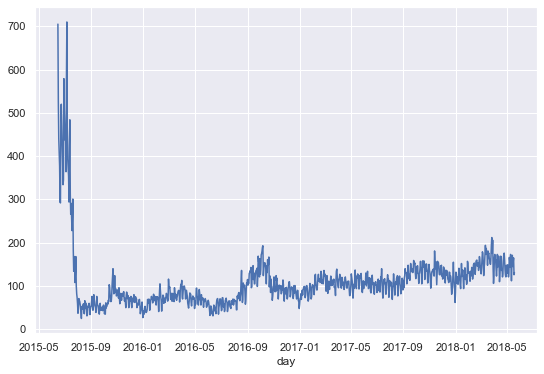

In [11]:
sns.set(rc={'figure.figsize': (9, 6)})
event_data_train.groupby(['day'])['user_id'].nunique().plot()

<b>Посмотрим, как распределены пользователи по количеству баллов, набранных за курс.</b>

In [12]:
event_data_table = event_data_train.pivot_table(index='user_id',
                                               columns='action',
                                               values='step_id',
                                               aggfunc='count').fillna(0)
event_data_table.head()

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1.0,0.0,0.0,1.0
2,9.0,9.0,2.0,10.0
3,91.0,87.0,30.0,192.0
5,11.0,11.0,4.0,12.0
7,1.0,1.0,0.0,1.0


In [13]:
event_data_table = event_data_table.reset_index()
event_data_table.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1.0,0.0,0.0,1.0
1,2,9.0,9.0,2.0,10.0
2,3,91.0,87.0,30.0,192.0
3,5,11.0,11.0,4.0,12.0
4,7,1.0,1.0,0.0,1.0


<AxesSubplot:>

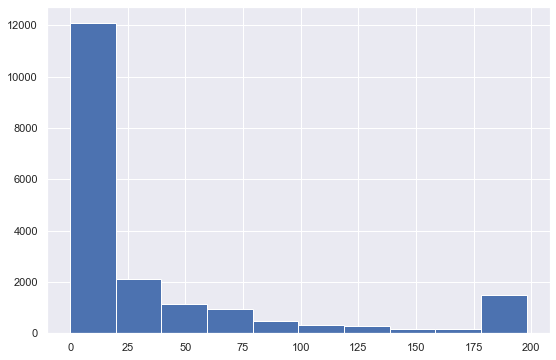

In [14]:
event_data_table['discovered'].hist()  # добавить заголовки к графику !!!

<AxesSubplot:>

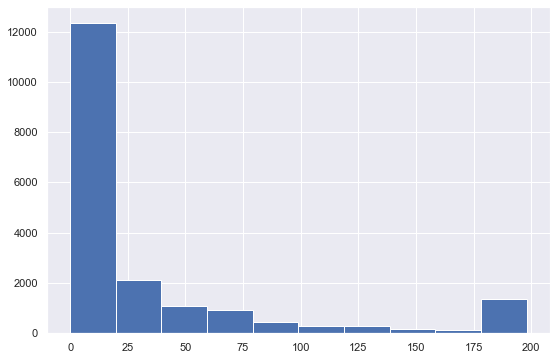

In [15]:
event_data_table['passed'].hist()

<AxesSubplot:>

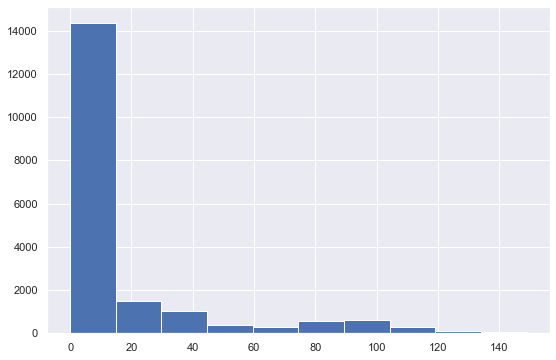

In [16]:
event_data_table['started_attempt'][event_data_table.started_attempt < 150].hist()  # нужно увеличить график

<AxesSubplot:>

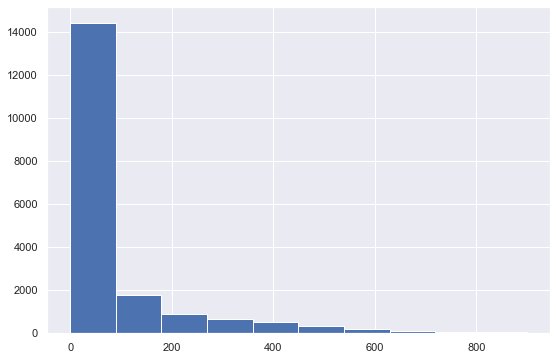

In [17]:
event_data_table['viewed'][event_data_table.viewed < 900].hist()  # Нужно увеличить график

Для нашей задачи очень важная информация как долго пользователь взаимодействовал с контентом, насколько хорошо у него это получалось.

Рассчитаем для каждого юзера сколько у него было данных, для которых был правильный correct submit.

In [18]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [19]:
submissions_data_train['date'] = pd.to_datetime(submissions_data_train['timestamp'], unit='s')
submissions_data_train['day'] = submissions_data_train.date.dt.date
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [20]:
users_scores = submissions_data_train.pivot_table(index='user_id',
                                                 columns='submission_status',
                                                 values='step_id',
                                                 aggfunc='count').fillna(0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2.0,0.0
1,3,29.0,23.0
2,5,2.0,2.0
3,8,9.0,21.0
4,14,0.0,1.0


<b>Получим для каждого user_id сколько у него было правильных и неправильных сабмитов за всю историю общения эти пользователей со степиком.</b>

array([[<AxesSubplot:title={'center':'step_id'}>]], dtype=object)

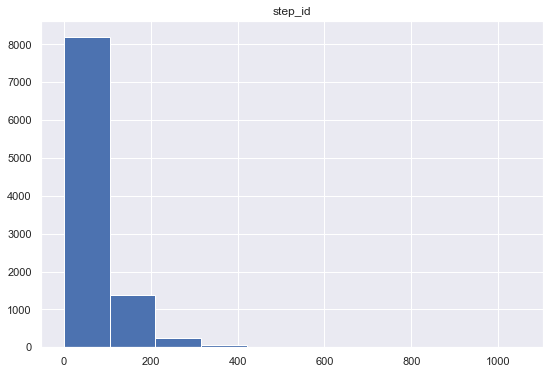

In [21]:
submissions_data_train.groupby('user_id').agg({'step_id':'count'}).hist()  # X - кол-во step_id, Y - кол-во юзеров

<b>Будем считать дропнувшимися всех пользователей, отсутствующих на курсе месяц</b>

Для каждого пользователя рассчитаем какие у него были промежутки в перерывах между уникальными днями, когда он проходил курс. Далее посмотрим на картину по всем пользователям и примем статистическое решение.

Ответить на этот вопрос более статистически нам помогут данные events_data. Мы посмотрим как в среднем распределены перерывы в решении курса у юзеров. И, тем самым, ответим на вопрос - какой временной промежуток отсутствия на курсе можно считать пороговым, после которого мы будем считать пользователя дропнувшимся.

Для этого сделаем следующее: посмотрим для каждого пользователя какие перерывы в днях у него наблюдаются в момент прохождения курса.

В течение дня может быть несколько событий с одним и тем же timestamp, но нам эта информация не нужна. <b>Если человек хотя бы раз зашел в этот день будем считать его активным в этот день.</b>

Мы хотим взять уникальные значения по user_id и day, а timestamp взять первый или последний.

In [22]:
event_data_train.shape

(3480703, 6)

In [23]:
event_data_train_droped = event_data_train[['user_id', 'day', 'timestamp']].drop_duplicates(['user_id', 'day'])

In [24]:
event_data_train_droped.shape

(117106, 3)

In [25]:
event_gap = event_data_train_droped.groupby('user_id')['timestamp'].apply(list).apply(np.diff)

In [26]:
event_gap.head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

Метод apply поместил все значения, которые мы получили в прошлом запросе, в списки, а метод np.diff посчитал разность между ближайшими наблюдениями

In [27]:
# Теперь у нас в Seies сохранены для каждого пользователя и
# для всех пользователей в том числе значения разницы между двумя ближайшими заходами на курс.
event_gap = pd.Series(np.concatenate(event_gap.values, axis=0))
event_gap.head()

0    4843602
1    6899249
2     182484
3      93710
4    2768870
dtype: int32

In [28]:
# Для получения разницы в днях нужно все значения из gap_data поделить на: 24 60 60
event_gap = event_gap / (24 * 60 * 60)
event_gap.head()

0    56.060208
1    79.852419
2     2.112083
3     1.084606
4    32.047106
dtype: float64

<AxesSubplot:>

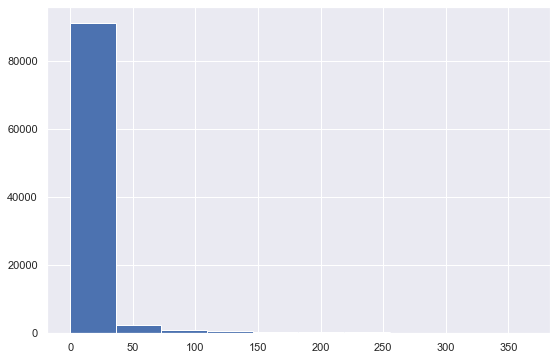

In [29]:
event_gap[event_gap <= 365].hist()

<b>Большая часть всех gap'ов между двумя заходами укладывается в диапазон между 0 и 25 днями.</b>

In [30]:
event_gap.quantile(0.95)

59.760440972222156

In [31]:
event_gap.quantile(0.90)

18.325995370370403

Только 5% пользователей возвращаются на курс после перерыва в 2 месяца.
А 90% укладываются в интервал до 18 дней.

Если человек не получил сертификат и при этому более 30 дней отсутствует на платформе - считаем, что он дропнулся с курса.

In [32]:
event_data_train.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


2018-05-19 - финальный день курса. Давайте отсчитывать отвалившихся пользователей от этого дня.

In [33]:
user_data = event_data_train.groupby('user_id', as_index=False).agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})
user_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [34]:
# (now - user-last-timestamp) > drop-out-treshold
user_data['is_gone_user'] = (event_data_train['timestamp'].iloc[-1] - user_data.last_timestamp) > (24 * 60 * 60 * 30)
user_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


Теперь нужно уточнить, что эти пользователи не прошли курс и тогда задача будет решена

In [35]:
user_data = user_data.merge(users_scores, on='user_id', how='outer').fillna(0)
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [36]:
user_data = user_data.merge(event_data_table, on='user_id', how='outer')
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1.0,0.0,0.0,1.0
1,2,1519226966,True,2.0,0.0,9.0,9.0,2.0,10.0
2,3,1444581588,True,29.0,23.0,91.0,87.0,30.0,192.0
3,5,1499859939,True,2.0,2.0,11.0,11.0,4.0,12.0
4,7,1521634660,True,0.0,0.0,1.0,1.0,0.0,1.0


Сейчас в данной таблице есть вся интересующая информация о пользователе, кроме одной важной фичи - сколько уникальных дней пользователь был в сервисе.

In [37]:
user_days = event_data_train.groupby('user_id')['day'].nunique().to_frame().reset_index()
user_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [38]:
user_data = user_data.merge(user_days, on='user_id', how='outer')
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1.0,0.0,0.0,1.0,1
1,2,1519226966,True,2.0,0.0,9.0,9.0,2.0,10.0,2
2,3,1444581588,True,29.0,23.0,91.0,87.0,30.0,192.0,7
3,5,1499859939,True,2.0,2.0,11.0,11.0,4.0,12.0,2
4,7,1521634660,True,0.0,0.0,1.0,1.0,0.0,1.0,1


In [39]:
# Проверяем, что мы никого не потеряли, смотрим на количество юзеров.
event_data_train.user_id.nunique() == user_data.user_id.nunique()

True

Последняя колонка которую мы хоти добавить - показатель того, что пользователь успешно закончил курс.

Например, пользователь набрал более 175 пройденных шагов.

In [40]:
user_data['passed_course'] = user_data.passed > 175
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1.0,0.0,0.0,1.0,1,False
1,2,1519226966,True,2.0,0.0,9.0,9.0,2.0,10.0,2,False
2,3,1444581588,True,29.0,23.0,91.0,87.0,30.0,192.0,7,False
3,5,1499859939,True,2.0,2.0,11.0,11.0,4.0,12.0,2,False
4,7,1521634660,True,0.0,0.0,1.0,1.0,0.0,1.0,1,False


In [41]:
user_data.groupby('passed_course')['user_id'].count()

passed_course
False    17844
True      1390
Name: user_id, dtype: int64

## Попробуем, анализируя поведение пользователя за его первые несколько дней, после которых он начал курс, предсказать - правда ли, что он успешно закончит курсу или дропнется с него.

Начнём, например, с 3-х дней. Для начала можно в принципе проверить насколько это адекватно, потому что у нас есть данные про то сколько уникальных дней пользователь потратил на прохождение курса - колонка day

In [42]:
user_data[user_data.passed_course].day.describe()

count    1390.000000
mean       24.996403
std        18.971028
min         1.000000
25%        13.000000
50%        21.000000
75%        31.000000
max       236.000000
Name: day, dtype: float64

<AxesSubplot:>

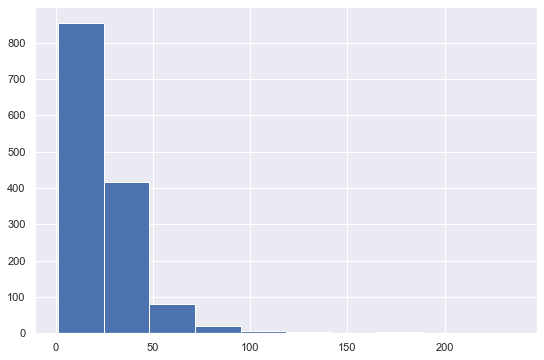

In [43]:
user_data[user_data.passed_course].day.hist()

Мы видим, что медиана 21, т.е. половина пользователей решает более 21 дней, поэтому 3 дня кажется адекватным порогом.

Отобрём те наблюдения, которые мы будем использовать для обучения <i>event_data_train</i>, т.е. события, происходящие с пользователем в течение его первых трёх дней из общего датафрейма.

Сейчас здесь для каждого пользователя лежит вся его информация про все его действия на протяжении всей истории, доступной нам в этой выгрузке. Нам бы нужно для каждого юзера отобрать только его события, укладывающиеся в диапазон от его первого события плюс 3 дня.

In [44]:
# Отберём данные о первых активных действиях пользователя на курсе
user_min_time = event_data_train.groupby('user_id', as_index=False).agg({'timestamp':'min'}).rename(columns={'timestamp':'min_timestamp'})
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [45]:
user_data = user_data.merge(user_min_time, on='user_id', how='outer')
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1.0,0.0,0.0,1.0,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9.0,9.0,2.0,10.0,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91.0,87.0,30.0,192.0,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11.0,11.0,4.0,12.0,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1.0,1.0,0.0,1.0,1,False,1521634660


Нам теперь нужно для данных, хранящихся в <i>event_data_train</i> отобрать для каждого пользователя только события, вписывающиеся в промежуток первых трёх дней после начала курса.

In [46]:
event_data_train.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Мы не можем сделать фильтрацию только по <i>user_id</i>, нам нужно сложное комбинированное условие по <i>user_id</i> и <i>timestamp</i>. Для каждого <i>user_id</i> границы <i>timestamp</i> разные и как к этому подойти - непонятно.

Давайте создадим в <i>events_data_train</i> новую колонку <i>user_time</i>

In [47]:
event_data_train['user_time'] = event_data_train.user_id.map(str) + '_' + event_data_train.timestamp.map(str)
event_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [48]:
learning_time_treshold = 3 * 24 * 60 * 60
user_min_time['user_learning_time_treshold'] = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_treshold).map(str)
user_min_time.head()

,user_id,min_timestamp,user_learning_time_treshold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860


In [49]:
# Сделаем мёрдж наших данных с датафреймом user_min_time, отобрав из него только нужные нам данные
event_data_train = event_data_train.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
event_data_train.shape

(3480703, 8)

In [50]:
event_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [51]:
# Нам теперь для каждого пользователя достаточно просто узнать - "правда ли, что его время выполнения каждого действия 
# вписыается в нужный нам диапазон?".

# И тут нам на помощь приходит то, что строки можно сравнивать так же как инты
event_data_three_days = event_data_train[event_data_train.user_time <= event_data_train.user_learning_time_treshold]
event_data_three_days.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [52]:
event_data_three_days.shape

(1014985, 8)

In [53]:
# Проверка
event_data_three_days.groupby('user_id').day.nunique().max()

4

Такое может быть, например, когда пользователь начал 1-го числа в середине дня, и трое суток в этом случае заденут и четвёртое число тоже. Но число больше 4-х мы уже никак не можем ожидать в наших данных, потому что это заложено в наш с вами порог.

In [54]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [55]:
# Тоже самое с submissions_data_train
submissions_data_train['user_time'] = submissions_data_train.user_id.map(str) + '_' + submissions_data_train.timestamp.map(str)
submissions_data_train = submissions_data_train.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
submissions_data_three_days = submissions_data_train[submissions_data_train.user_time <= submissions_data_train.user_learning_time_treshold]
submissions_data_three_days.groupby('user_id').day.nunique().max()

4

In [56]:
submissions_data_three_days.head()

,step_id,timestamp,submission_status,user_id,date,day,user_time,user_learning_time_treshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434605177
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,15853_1434348188,15853_1434605177
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,15853_1434347371,15853_1434605177


Соберём первый простенький вариант с фичами и целевой переменной и попробуем обучить хотя бы базовую модель, чтобы посмотреть, что у нас, в принципе, что-то получается и работает. Или это бесполезная задача и никакой точности прогнозирования за первые 3 дня добиться не удастся.

Заведём датафрейм <i>X</i>, который постепенно будем наполнять данными.

In [57]:
X = submissions_data_three_days.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={
    'day':'days'
})
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [58]:
step_tried = submissions_data_three_days.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(columns={
    'step_id':'steps_tried'
})
step_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [59]:
X = X.merge(step_tried, on='user_id', how='outer')
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [60]:
X.shape

(8913, 3)

In [61]:
submissions_data_table = submissions_data_three_days.pivot_table(index='user_id',
                                                           columns='submission_status',
                                                           values='step_id',
                                                           aggfunc='count',
                                                           fill_value=0).reset_index()
submissions_data_table.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,8,9,21
3,14,0,1
4,16,23,27


In [62]:
X = X.merge(submissions_data_table, on='user_id', how='outer')
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


In [63]:
X.shape

(8913, 5)

In [64]:
X['correction_ratio'] = X.correct / (X.correct + X.wrong)
X.head()

,user_id,days,steps_tried,correct,wrong,correction_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [65]:
event_data_three_days.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [66]:
viewed_steps_count = event_data_three_days.pivot_table(index='user_id',
                                                    columns='action',
                                                    values='step_id',
                                                    aggfunc='count',
                                                    fill_value=0).reset_index()[['user_id', 'viewed']]
viewed_steps_count.head()

action,user_id,viewed
0,1,1
1,2,9
2,3,20
3,5,1
4,7,1


In [67]:
X = X.merge(viewed_steps_count, on='user_id', how='outer')
X.head()

,user_id,days,steps_tried,correct,wrong,correction_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [68]:
X.shape

(19234, 7)

In [69]:
X = X.fillna(0)

In [70]:
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1.0,0.0,0.0,1.0,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9.0,9.0,2.0,10.0,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91.0,87.0,30.0,192.0,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11.0,11.0,4.0,12.0,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1.0,1.0,0.0,1.0,1,False,1521634660


In [71]:
X = X.merge(user_data[['user_id', 'passed_course', 'is_gone_user']], on='user_id', how='outer')
X.head()

,user_id,days,steps_tried,correct,wrong,correction_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [72]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [73]:
X.head()

,user_id,days,steps_tried,correct,wrong,correction_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


Теперь в <i>X</i> находятся пользователи, которые либо прошли курс, либо бросили его.

Теперь можно создать колонку, отвечающую за то - дропнулся человек с курса или его прошёл.

In [74]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16590
True           False             136
               True             1254
Name: user_id, dtype: int64

Все пользователи, не прошедшие курс(<i>passed_course = False</i>), помечены как дропнутые (<i>is_gone_user = True</i>). А все прошедшие курс могут быть как дропнутые(<i>is_gone_user = True</i>), так и нет(<i>is_gone_user = False</i>). Которые не дропнулись - это те, кто совсем недавно курс прошёл и у них ещё какие-то данные в логах остались.

Поэтому нашей целевой переменной здесь является <i>passed_course</i>.

In [75]:
y = X.passed_course.map(int)
y.head()

0    0
1    0
2    0
3    0
4    1
Name: passed_course, dtype: int64

In [76]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)
X.head()

,user_id,days,steps_tried,correct,wrong,correction_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [77]:
X = X.set_index(X.user_id)
X = X.drop(['user_id'], axis=1)
X.head()

,days,steps_tried,correct,wrong,correction_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


<i>X</i> теперь стал более похож на обучающую выборку с которой можно провести эксперименты - логистическая регрессия, дерево решений, оценка метрик, замена параметров и т.д.

Проделав всё это, можно будет ответить на вопрос - сможем ли мы предсказать отток студентов за первые несколько дней.